Preprocessing audio data seems extremely important and is not obvious.

Let's first pinpoint the information in our audio files that seems to be worthwhile to visualize.

In [1]:
from pathlib import Path
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastprogress import progress_bar
import librosa.display
from scipy.io import wavfile
from scipy.ndimage import center_of_mass
import PIL

In [2]:
trn_paths = list(Path('data/audio_train/').iterdir())
tst_paths = list(Path('data/audio_test/').iterdir())

In [3]:
%%time

trn_srs = []
trn_lengths = []
max_vals = []

for path in Path('data/audio_train').iterdir():
    x, sr = librosa.core.load(path, sr=None)
    trn_srs.append(sr)
    trn_lengths.append(x.shape[0] / sr)
    max_vals.append(np.max(x))

CPU times: user 5 s, sys: 2.53 s, total: 7.52 s
Wall time: 13.4 s


In [4]:
np.quantile(trn_lengths, 0.15), np.quantile(trn_lengths, 0.31), np.quantile(trn_lengths, 0.56), np.quantile(trn_lengths, 0.75)

(1.02, 2.0, 5.0, 9.38)

15% of data is under 1 second long, 31% under 2 seconds. These numbers are maybe not that telling as there is some silence in some of the files.

I manually inspected the files and it does not seem that removing silence is the way to go. It's hard to pick a hyperapameter (`top_db`) that will perform well across different recordings.

But maybe we don't have to go this route at all. Let's identify the meaningful portions in audio files and try to zone in on those.

In [5]:
SR = 22050

def zone_in(path, length=2):
    # length given in seconds
    
    x, sr = librosa.core.load(path, sr=SR)
    if np.count_nonzero(x) == 0: # accomodating for the corrupted files in test
        x = np.zeros(length*SR) 
    else:
        density = np.convolve(np.abs(x), np.ones([length*sr]), mode='valid')
        center_idx = np.argmax(density)
        half_of_length = length*sr//2 # measured in samples
        if center_idx < half_of_length:
            x = x[:length*sr]
        else:
            x = x[center_idx-half_of_length:center_idx+half_of_length]

    return np.pad(x, (0, length*SR))[:length*SR]

In [6]:
x, sr = librosa.load(trn_paths[3581], sr=SR)
Audio(x, rate=sr)

In [7]:
x = zone_in(trn_paths[3581])
Audio(x, rate=sr)

Seems to work!

In [8]:
dir_name = '22k_2sec_centered'

!rm -rf data/audio_train_{dir_name}
!rm -rf data/audio_test_{dir_name}

!mkdir data/audio_train_{dir_name}
!mkdir data/audio_test_{dir_name}

In [9]:
def zone_in_and_save(path, save_to):
    x = zone_in(path)
    librosa.output.write_wav(f'{save_to}/{path.name}', x, SR, norm=False)

In [10]:
def process_train(path): zone_in_and_save(path, f'data/audio_train_{dir_name}')
def process_test(path): zone_in_and_save(path, f'data/audio_test_{dir_name}')

In [ ]:
%%time
# unfortunately unable to run these calculations in parallel due to how much resources the processing of a single
# file requires, some additional info: https://stackoverflow.com/a/54756707

for path in progress_bar(trn_paths): process_train(path)
for path in progress_bar(tst_paths): process_test(path)

This preprocessing is okay, but think about the produced spectorgrams for files under 2 seconds of length and under 4 seconds of length. This situation is further exacerbated when we consider that many of the files have a lot of silence or very quiet sounds.

For a file that is under 2 seconds long, two unfortunate things will happen.

1. There will be a large portion of the spectrograms that will contain no information (wasted computation).
2. The most interesting part is likely to appear off-center. In the case of very short files, it is bound to exist all the way to the left of the spectrograms. This is bad news.

Point #2 is quite important. Because of how the receptive field works, anything that is to the side in an image will receive less scrutiny from the model than what appears in the center.

This will lead to wasting computation and not utilizing the full capabitilites of our model.

In [14]:
SR = 22050

def zone_in_center(path, length=2):
    # length given in seconds
    
    x, sr = librosa.core.load(path, sr=SR)
    if np.count_nonzero(x) == 0: # accomodation for the corrupted files in test, otherwise we get an error
        x = np.zeros(length*SR) 
    else:
        x = np.concatenate((np.zeros(length//2*SR), x, np.zeros(length//2*SR) )) # <- padding on the left and right
                                                                                 # to accomodate short files
        density = np.convolve(np.abs(x), np.ones([sr//2]), mode='valid') # a window of 0.5s is an arbitrary choice
        center_idx = np.argmax(density) + sr//4
    
        half_of_length = length*sr//2 # measured in samples
        x = x[center_idx-half_of_length:center_idx+half_of_length]

    return x

In [12]:
x, sr = librosa.load(trn_paths[121], sr=SR)
Audio(x, rate=sr)

In [13]:
x  = zone_in_center(trn_paths[121])

In [14]:
Audio(x, rate=sr)

In [15]:
def zone_in_and_save(path, save_to):
    x = zone_in_center(path)
    librosa.output.write_wav(f'{save_to}/{path.name}', x, SR, norm=False)

In [16]:
def process_train(path): zone_in_and_save(path, f'data/audio_train_{dir_name}')
def process_test(path): zone_in_and_save(path, f'data/audio_test_{dir_name}')

In [17]:
dir_name = '22k_2sec_better_centered'

!rm -rf data/audio_train_{dir_name}
!rm -rf data/audio_test_{dir_name}

!mkdir data/audio_train_{dir_name}
!mkdir data/audio_test_{dir_name}

In [18]:
%%time

for path in progress_bar(trn_paths): process_train(path)
for path in progress_bar(tst_paths): process_test(path)

CPU times: user 16h 41min 46s, sys: 10min 20s, total: 16h 52min 7s
Wall time: 3h 10min 32s


This method is not perfect but it should at least make the half a second in the center of the spectrograms contain something interesting. One way to improve on this would be to instead of applying a convolution, slide a gaussian window of the duration of the sample we want to take.

Also, there is still a lot of data that we could salvage for training (for instance, we could cut out more pieces from longer files and possibly work towards balancing the dataset). For our intents and purposes, this should be a good enough approach - we will know more when we train our first model.

## Generate spectrogramss

In [2]:
trn_paths = list(Path('data/audio_train_22k_2sec_better_centered/').iterdir())
tst_paths = list(Path('data/audio_test_22k_2sec_better_centered/').iterdir())

In [3]:
x, sr = librosa.load(trn_paths[0])

In [4]:
Audio(x, rate=sr)

In [5]:
hop_length = 512
n_fft = 2048
S = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)

Here are examples of some of the spectrograms types that we will generate.

/home/radek/.local/lib/python3.7/site-packages/librosa/display.py:725: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


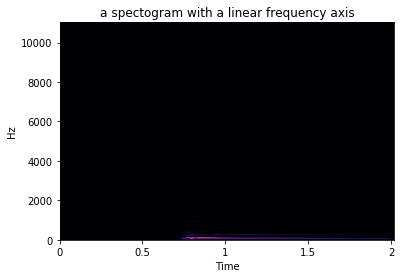

In [6]:
ax = librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='linear')
plt.title('a spectrograms with a linear frequency axis');

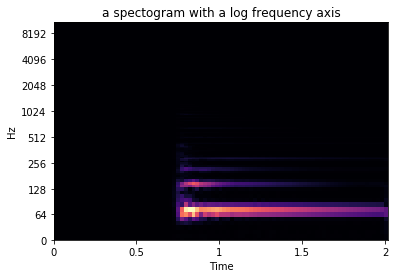

In [7]:
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log')
plt.title('a spectrograms with a log frequency axis');

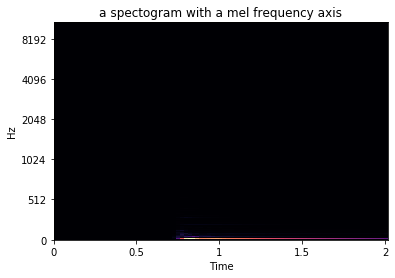

In [8]:
ax = librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')
plt.title('a spectrograms with a mel frequency axis');

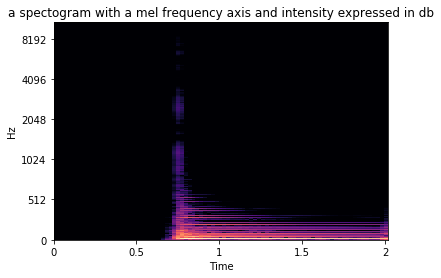

In [9]:
S_db = librosa.amplitude_to_db(abs(S))
ax = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.title('a spectrograms with a mel frequency axis and intensity expressed in db');

In [10]:
dir_name = '22k_2sec_better_centered'

trn_paths = list(Path(f'data/audio_train_{dir_name}/').iterdir())
tst_paths = list(Path(f'data/audio_test_{dir_name}/').iterdir())

In [11]:
sz = 224

matplotlib.use('agg') # without this we will get a memory leak when running fig generation and saving in a loop

def save_spectrograms(path, save_to, y_axis='linear', loudness='linear'):
    hop_length = 512
    n_fft = 2048

    fig = plt.figure(figsize=[0.72, 0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    x, sr = librosa.load(path)
    S = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
    if loudness == 'db': S = librosa.amplitude_to_db(abs(S))
    ax = librosa.display.specshow(S, sr=sr, x_axis='time', y_axis=y_axis)    
    ax.figure.savefig(f'{save_to}/{path.stem}.png', dpi=400, bbox_inches='tight', pad_inches=0)
    
    # saving, loading, resizing and saving strikes me as inefficient / could be losing quality
    # but I don't think this is the time to keep figuring out how else to do this
    im = PIL.Image.open(f'{save_to}/{path.stem}.png')
    im.resize((sz,sz), resample=PIL.Image.BICUBIC).save(f'{save_to}/{path.stem}.png')
    plt.close('all')

In [12]:
y_axis_and_loudness_options = [
    ['linear', 'linear', 'log', 'log', 'mel', 'mel'],
    ['linear', 'db', 'linear', 'db', 'linear', 'db']
]

for y_axis, loudness in zip(*y_axis_and_loudness_options):
    !rm -rf data/img_train_{dir_name}_{y_axis}_{loudness}
    !rm -rf data/img_test_{dir_name}_{y_axis}_{loudness}

    !mkdir data/img_train_{dir_name}_{y_axis}_{loudness}
    !mkdir data/img_test_{dir_name}_{y_axis}_{loudness}

    def process_train(path): save_spectrograms(path, f'data/img_train_{dir_name}_{y_axis}_{loudness}', y_axis, loudness)
    def process_test(path): save_spectrograms(path, f'data/img_test_{dir_name}_{y_axis}_{loudness}', y_axis, loudness)
    
    for path in progress_bar(trn_paths): process_train(path)
    for path in progress_bar(tst_paths): process_test(path)

# Generate high resolution spectrogramss

In [2]:
from spectral_hyperresolution.linear_reassignment_pytorch_vectorized import high_resolution_spectrograms

In [3]:
dir_name = '22k_2sec_better_centered'

trn_paths = list(Path(f'data/audio_train_{dir_name}/').iterdir())
tst_paths = list(Path(f'data/audio_test_{dir_name}/').iterdir())

In [4]:
x, sr = librosa.load(trn_paths[1])

In [5]:
q = 2;
tdeci = 197;
over = 10;
noct = 26.2;
minf = 1.4e-3;
maxf = 0.5;

In [6]:
%%time
spectrograms = high_resolution_spectrograms(x.reshape(-1,1), q, tdeci, over, noct, minf, maxf, 'cuda', chunks=4)

CPU times: user 2.57 s, sys: 588 ms, total: 3.16 s
Wall time: 3.21 s


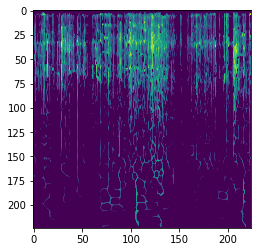

In [7]:
plt.imshow(librosa.core.amplitude_to_db(spectrograms.cpu().T))

In [8]:
sz = 224
matplotlib.use('agg') # without this we will get a memory leak when running fig generation and saving in a loop


def save_spectrograms(path, save_to):
    x, sr = librosa.load(path, sr=None)
    spectrograms = high_resolution_spectrograms(x.reshape(-1, 1), q, tdeci, over, noct, minf, maxf, 'cuda', chunks=4)
    
    fig = plt.figure(figsize=[0.72, 0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    ax.matshow(librosa.core.amplitude_to_db(spectrograms.cpu().T))
    ax.figure.savefig(f'{save_to}/{path.stem}.png', dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close('all')
    
    # saving, loading, resizing and saving strikes me as inefficient / could be losing quality
    # but I don't think this is the time to keep figuring out how else to do this
    im = PIL.Image.open(f'{save_to}/{path.stem}.png')
    im.resize((sz,sz), resample=PIL.Image.BICUBIC).save(f'{save_to}/{path.stem}.png')

In [9]:
for q in [1, 2, 4, 8]:
    !rm -rf data/img_train_hires_{dir_name}_{q}
    !rm -rf data/img_test_hires_{dir_name}_{q}

    !mkdir data/img_train_hires_{dir_name}_{q}
    !mkdir data/img_test_hires_{dir_name}_{q}
    
    def process_train(path): save_spectrograms(path, f'data/img_train_hires_{dir_name}_{q}')
    def process_test(path): save_spectrograms(path, f'data/img_test_hires_{dir_name}_{q}')
    
    for path in progress_bar(trn_paths): process_train(path)
    for path in progress_bar(tst_paths): process_test(path)